### Goal
Compute baseline model - tissue mean across individuals using the TPM values.

### TODO
1. Compute baseline model
2. Check baseline model
    - how are the avg(TPM) values per gene per tissue
    - identify set of genes for which the avg(TMP) not/highly varie across tissues
3. TPM to log ratios (relative expression with respect to the mean within one tissue)<br/>
    3.1 plot brain against blood per individual
4. Compute metadata
    - dispersion index per gene (better distinguish between genes which more likely to be tissue specific / genes which are expressed in all tissues)
    - top tissues (most samples available)
    - top individuals (most tissues available)

### Conclusions
1. Compute baseline model
    - The model can be found under `/s/projects/rep/processed/models/baseline/baseline_mean_tissues.pkl`
2. Check baseline model
    - Gene expression distribution is similar for all tissues
    - Mito Genes tend to be strongly expression over all tissues
    - Top tissue - specific genes, with a very strong signal:
        + ENSG00000188536.12 (HBA2, enhanced in bone marrow - whole blood)
        + ENSG00000197971.14 (MBP, enhanced in brain - spinal cord)
        + ENSG00000204983.12 (PRSS1, enhanced in pancreas)
        + ENSG00000206172.8 (HBA1, enhanced in bone marrow - whole blood)
        + ENSG00000244734.3 (HBB, enhanced in bone marrow - whole blood)
        + ENSG00000275896.5 (PRSS2, enhanced in pancreas)
        + ENSG00000259384.6 (GH1, pituitary gland)
3. TPM to log ratios 
    - The log ratios values can be found under `/s/projects/rep/processed/gtex/recount/recount_gtex_logratios.h5ad`
    - Top 10 Tissues:
    
    Muscle - Skeletal                  435<br/>
    Whole Blood                        429<br/>
    Skin - Sun Exposed (Lower leg)     371<br/>
    Adipose - Subcutaneous             358<br/>
    Lung                               354<br/>
    Artery - Tibial                    343<br/>
    Thyroid                            340<br/>
    Nerve - Tibial                     310<br/>
    Esophagus - Mucosa                 309<br/>
    Cells - Transformed fibroblasts    290<br/>
    
    - 3.1. Plot brain against blood per individual
    
4. Compute metadata
    - <font color="red">Still missing</font>

In [1]:
import os
import pandas as pd
import numpy as np

import plotly
import plotly.plotly as py
from plotly.graph_objs import graph_objs
import plotly.tools as tls
import matplotlib.pyplot as plt
import seaborn as sns

# set credentials
plotly.tools.set_credentials_file(username='gium', api_key='nUFs5UnmuBR3pEbGIMj8')

import rep.preprocessing_new as p
import rep.plot as po

import warnings; warnings.simplefilter('ignore')

%matplotlib inline


/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88



### 1. Compute baseline model

In [39]:
def compute_baseline(repobj):
    """
    NOT USED ANYMORE
    Compute average for each tissue across samples
    
    Args:
        repobj (:obj:RepAnnData): summarized experiment genes x samples
    
    Returns:
        DataFrame containing x_ij - mean expression of gene j in tissue i.
    """
    tissues = sorted(repobj.samples['Tissue'].drop_duplicates().tolist())
    Y_mean_tissue = np.zeros((len(tissues),len(repobj.genes_names)))
    
    # find min value
    matrix = np.array(repobj.X)
    min_value = np.min(matrix[matrix != 0.])
    print(f'min_value = {min_value}')
    
    # compute the sum(log2 TPM)/n
    for t in tissues:
        slice_bytissue = np.array(repobj[repobj.samples['Tissue'] == t].X)

        # make sure 0 are replaced with very small numbers
        slice_bytissue[slice_bytissue==0]=min_value/10
        
        mean_value = np.mean(np.log2(slice_bytissue),axis=0)
        Y_mean_tissue[tissues.index(t),:] = mean_value
    
    out = pd.DataFrame(data = Y_mean_tissue, columns = repobj.genes_names, index = tissues)
    return out


In [40]:
def compute_baseline_with_epsilon(repobj, epsilon = 1):
    """Compute average for each tissue across samples
    
    Args:
        repobj (:obj:RepAnnData): summarized experiment genes x samples
    
    Returns:
        DataFrame containing x_ij - mean expression of gene j in tissue i.
    """
    tissues = sorted(repobj.samples['Tissue'].drop_duplicates().tolist())
    Y_mean_tissue = np.zeros((len(tissues),len(repobj.genes_names)))
    
   
    # compute the sum(log2 TPM)/n
    for t in tissues:
        slice_bytissue = np.array(repobj[repobj.samples['Tissue'] == t].X)
        slice_bytissue = slice_bytissue + epsilon
        
        mean_value = np.mean(np.log2(slice_bytissue),axis=0)
        Y_mean_tissue[tissues.index(t),:] = mean_value
    
    out = pd.DataFrame(data = Y_mean_tissue, columns = repobj.genes_names, index = tissues)
    return out


In [82]:
path = os.path.join(os.readlink(os.path.join("..","..","data")),"processed")

In [83]:
gtex = p.RepAnnData.read_h5ad(os.path.join(path, "gtex","recount","recount_gtex_norm_tmp.h5ad"))

In [84]:
# baseline_prediction = compute_baseline(gtex)
baseline_prediction = compute_baseline_with_epsilon(gtex)
baseline_prediction.to_pickle(os.path.join(path,"models","baseline","baseline_mean_tissues.pkl"))

### 2. Check baseline model
- how correlates the mean expression cross tissues

In [26]:
path = os.path.join(os.readlink(os.path.join("..","..","data")),"processed")
baseline_prediction = pd.read_pickle(os.path.join(path,"models","baseline","baseline_mean_tissues.pkl"))

In [27]:
df=baseline_prediction.transpose()

In [28]:
df_reshaped = pd.melt(df.reset_index(), id_vars='index', value_vars=df.columns.tolist())
df_reshaped.shape

(1056396, 3)

In [29]:
df_reshaped[:10]

index                variable     value
0  ENSG00000000003.14  Adipose - Subcutaneous  5.232324
1   ENSG00000000005.5  Adipose - Subcutaneous  4.357264
2  ENSG00000000419.12  Adipose - Subcutaneous  5.326626
3  ENSG00000000457.13  Adipose - Subcutaneous  3.738048
4  ENSG00000000460.16  Adipose - Subcutaneous  2.554041
5  ENSG00000000938.12  Adipose - Subcutaneous  4.939397
6  ENSG00000000971.15  Adipose - Subcutaneous  7.045114
7  ENSG00000001036.13  Adipose - Subcutaneous  5.199118
8  ENSG00000001084.10  Adipose - Subcutaneous  4.475643
9  ENSG00000001167.14  Adipose - Subcutaneous  3.718427

- how are the avg(TPM) values per gene per tissue

In [30]:
# how are the avg(TPM) values per gene per tissue
# generate data
data = []
tissues = sorted(baseline_prediction.index.tolist())
tmp = baseline_prediction.iloc[:,:]
for t in tissues:
    data.append(graph_objs.Box(y=tmp.loc[t,:], name=t))

In [31]:
# plot figure
fig = graph_objs.Figure(data=data, layout=po.get_layout(_xlab = "Tissues",
                                                    _ylab = "log2(mean(TPM)) protein-coding genes",
                                                    _title = "Average expression profile tissue-specific in GTEx data"))
py.iplot(fig, filename='expression_per_tissue')

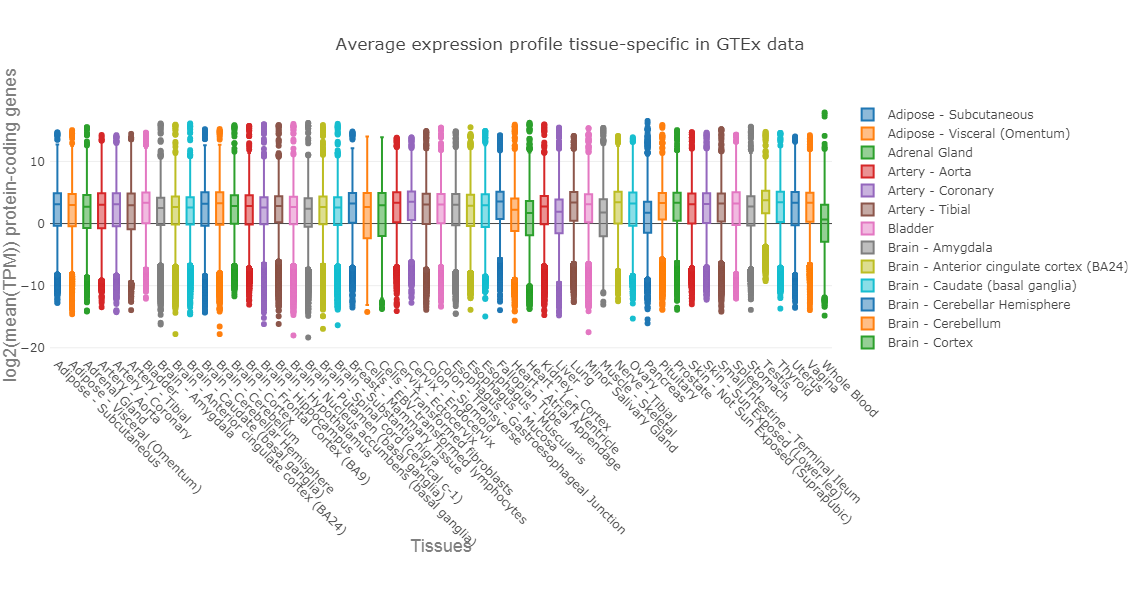

In [13]:
po.show_img("3_baseline_mean_tissue_gtex_files/avg_tmp_pcgenes_gtex.png")

- identify set of genes for which the avg(TPM) not/highly varie across tissues

In [32]:
stats=pd.DataFrame()
stats["mean"]=baseline_prediction.mean(axis=0)
stats["Std.Dev"]=baseline_prediction.std(axis=0)
stats["max"]=baseline_prediction.max(axis=0)
stats["min"]=baseline_prediction.min(axis=0)
stats["Var"]=baseline_prediction.var(axis=0)

In [33]:
stats["median"] = np.zeros(stats["Var"].shape[0])
for i in range(stats["Var"].shape[0]):
    stats["median"][i] = np.median(baseline_prediction.iloc[:,i])

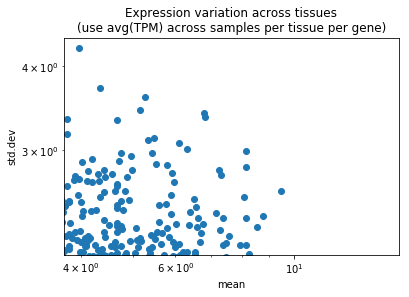

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111)

x = stats["mean"].tolist()
y = stats["Std.Dev"].tolist()

ax.scatter(x,y)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title('Expression variation across tissues\n(use avg(TPM) across samples per tissue per gene)')

# for i, txt in enumerate(stats.index.tolist()):
#     if x[i] <= 6000 and y[i]>8000:
#         ax.annotate(txt, (x[i], y[i]))
#         print(txt)

# plotly_fig = tls.mpl_to_plotly( fig )
# plotly_fig['layout']['showlegend'] = False
# plotly_fig['layout']['xaxis']['title'] = 'mean'
# plotly_fig['layout']['yaxis']['title'] = 'std.dev'
# py.iplot(plotly_fig,filename='expression_per_tissue')
x_label = 'mean'
y_label = 'std.dev'
data = pd.DataFrame(data = {x_label:np.log2(x), y_label:np.log2(y)})
ax = sns.scatterplot(x=x_label, y=y_label, data=data, alpha = 0.2)

- old plot

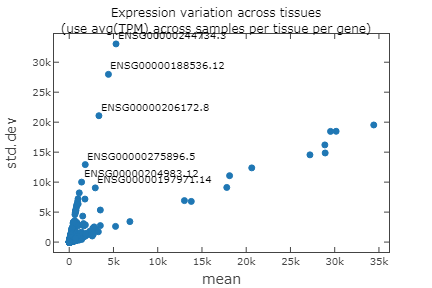

In [54]:
po.show_img("3_baseline_mean_tissue_gtex_files/variation_expression_acrosstissue.png")

### 3. TPM to log ratios

In [55]:
def to_log_ratio(repobj, baseline_prediction):
    # NOT USED ANYMORE
    x = np.zeros((repobj.X.shape[1],repobj.X.shape[0]))
    
    # find min value
    matrix = np.array(repobj.X)
    min_value = np.min(matrix[matrix != 0.])
    print(f'min_value = {min_value}')
    
    for i, sample in enumerate(repobj.samples_names):
        tissue = repobj.samples.loc[sample,'Tissue']
        
        # replace 0 with the smallest number
        a = np.array(repobj[sample].X,dtype=np.float32)
        a[a==0]=min_value/10
        
        b = np.array(baseline_prediction.loc[tissue,:],dtype=np.float32)
        
        # b already log2 transformed
        x[:,i] = np.maximum(-8, np.log2(a) - b)
    
    return x.transpose()

def to_log_ratio_with_epsilon(repobj, baseline_prediction, epsilon=1):
    
    x = np.zeros((repobj.X.shape[1],repobj.X.shape[0]))
    
    for i, sample in enumerate(repobj.samples_names):
        tissue = repobj.samples.loc[sample,'Tissue']
        
        a = np.array(repobj[sample].X,dtype=np.float32)
        a = a + epsilon
        
        b = np.array(baseline_prediction.loc[tissue,:],dtype=np.float32)
        
        # b already log2 transformed
        x[:,i] = np.log2(a) - b
    
    return x.transpose()

In [56]:
gtex = p.RepAnnData.read_h5ad(os.path.join(path, "gtex","recount","recount_gtex_norm_tmp.h5ad"))

In [94]:
# x_expression_ratios = to_log_ratio(gtex, baseline_prediction)
# LAST TRANFROMATION, AFTER ONLZ PLOTS
x_expression_ratios = to_log_ratio_with_epsilon(gtex, baseline_prediction)
min_val = np.min(x_expression_ratios)
print(f'min_value={min_val}')

min_value=-14.83470344543457


In [95]:
baseline_prediction.loc[['Lung','Brain - Cerebellar Hemisphere','Heart - Left Ventricle','Brain - Cerebellar Hemisphere']].iloc[:,:4]

ENSG00000000003.14  ENSG00000000005.5  \
Lung                                     4.074506           0.105833   
Brain - Cerebellar Hemisphere            1.788581           0.047404   
Heart - Left Ventricle                   2.043338           0.247529   
Brain - Cerebellar Hemisphere            1.788581           0.047404   

                               ENSG00000000419.12  ENSG00000000457.13  
Lung                                     5.249912            3.582350  
Brain - Cerebellar Hemisphere            5.002140            3.760146  
Heart - Left Ventricle                   4.392864            2.071691  
Brain - Cerebellar Hemisphere            5.002140            3.760146

In [96]:
gtex.X = x_expression_ratios

In [97]:
np.min(gtex.X)

-14.83470344543457

In [98]:
gtex.obs = gtex.obs.loc[:,['Parent_Tissue','Tissue','Individual','Indiv_Seq_Assay']]

In [99]:
file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_logratios.h5ad")
gtex.save(outname = file)

... storing 'Parent_Tissue' as categorical
... storing 'Tissue' as categorical
... storing 'Individual' as categorical
... storing 'Indiv_Seq_Assay' as categorical
... storing 'symbol' as categorical


'/s/project/rep/processed/gtex/recount/recount_gtex_logratios.h5ad'

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_logratios.h5ad")
gtex = p.RepAnnData.read_h5ad(file)

# list of tissues and parent tissues
tissues = sorted(list(set(gtex.samples['Tissue'].tolist())))
parent_tissue = sorted(list(set(gtex.samples['Parent_Tissue'].tolist())))

# generate colors
palette = sns.color_palette(None, len(parent_tissue)).as_hex()

# generate data
data = []

# PTEN "ENSG00000171862.9"
# TSPAN6 "ENSG00000000003.14"
# OPALIN - brain enriched ENSG00000197430.10
# TTN - muscles enriched ENSG00000155657.25 - hier they cut at 1200 (removed an outlier with TPM=8000 ish)
gene = 'ENSG00000000003.14'
gtex_tmp = gtex[:,gene]
for t in tissues:
    pt = list(set(gtex_tmp[gtex_tmp.obs['Tissue'] == t].obs['Parent_Tissue'].tolist()))[0]
    color_pt = palette[parent_tissue.index(pt)]
    data.append(graph_objs.Box(y=gtex_tmp[gtex_tmp.obs['Tissue'] == t].X, 
                                name=t,
                                fillcolor= color_pt,
                                marker = dict(color = color_pt)))


In [101]:
# plot figure
fig = graph_objs.Figure(data=data, layout=po.get_layout(_xlab = "Tissues",
                                                        _ylab = "log ratios",
                                                        _title = "Relative change of expression across tissues for ENSG00000000003"))
py.iplot(fig, filename='expression_per_tissue')

### old plot!!!!!  

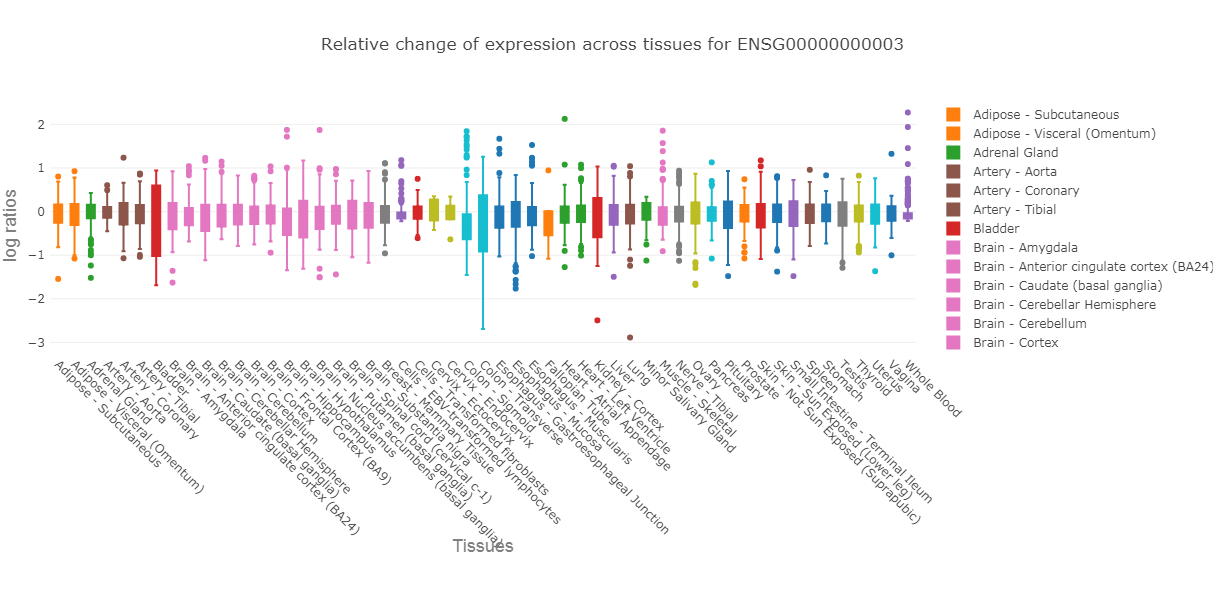

In [144]:
po.show_img('3_baseline_mean_tissue_gtex_files/logratios_ENSG00000000003_old.png')

### 3.1. Plot brain against blood per individual

In [3]:
file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_norm_tmp.h5ad")
gtex_tpm = p.RepAnnData.read_h5ad(file)

In [4]:
file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_logratios.h5ad")
gtex = p.RepAnnData.read_h5ad(file)

In [5]:
tissues_per_indiv = gtex.samples[['Individual','Tissue']].drop_duplicates().groupby(['Individual'], sort=True).size().sort_values(ascending=False)
print(tissues_per_indiv[:10])
print(tissues_per_indiv[:10].index.tolist())

Individual
GTEX-12WSD    36
GTEX-ZAB4     35
GTEX-13OW6    34
GTEX-NPJ8     32
GTEX-131YS    32
GTEX-11GSP    32
GTEX-13OW8    31
GTEX-YFC4     31
GTEX-13OVJ    31
GTEX-ZUA1     30
dtype: int64
['GTEX-12WSD', 'GTEX-ZAB4', 'GTEX-13OW6', 'GTEX-NPJ8', 'GTEX-131YS', 'GTEX-11GSP', 'GTEX-13OW8', 'GTEX-YFC4', 'GTEX-13OVJ', 'GTEX-ZUA1']


In [14]:
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from plotnine import *

def tissue_tissue(x_tissue, y_tissue, n_top, x_label, y_label, gtex_aux, min_=20, max_=20, width_=10, height_=10, title="", tpm=False):
    
    palette = sns.color_palette(None, n_top).as_hex()

    n = n_top - 1 
    # scatterplot values blood against brain 
    x = np.array([])
    y = np.array([])
    s = np.array([])
    
    genes = gtex_aux.X.shape[1]

    count = 0
    for indiv in tissues_per_indiv.index.tolist():
        if count == n:
            break
        indiv_samples = gtex_aux[gtex_aux.samples['Individual'] == indiv]
        # list of tissues for individual
        available_tissues = indiv_samples.obs[indiv_samples.obs['Tissue'].isin([x_tissue,y_tissue])]['Tissue'].drop_duplicates().tolist()
        if x_tissue != y_tissue and len(available_tissues) == 2 or \
            x_tissue == y_tissue and len(available_tissues) == 1:
            count += 1
            
            # take first sample for the individual which matches the tissue
            y_test_tissue =  indiv_samples[indiv_samples.obs['Tissue'] == y_tissue].X.reshape(genes, -1)[:, 0]
            x_test_tissue =  indiv_samples[indiv_samples.obs['Tissue'] == x_tissue].X.reshape(genes, -1)[:, 0]           
            s_color = [indiv] * len(x_test_tissue)
            
            x = np.append(x, x_test_tissue, axis=0)
            y = np.append(y, y_test_tissue, axis=0)
            s = np.append(s, s_color, axis=0)
    
    data = pd.DataFrame(data = {x_label:x, y_label:y, 'Individual':s})
 
    if min_ is None or max_ is None: 
        min_ = min(min(data[x_label]), min(data[y_label]))
        max_ = max(max(data[x_label]), max(data[y_label]))
        
    fig = (
        ggplot(data, aes(x=x_label, y=y_label)) + 
        geom_bin2d(bins = 40) +
        theme_bw() + 
        facet_wrap('~Individual', ncol = 10) + 
        theme(figure_size = (width_, height_)) + 
        ggtitle(title) + 
        xlim(min_, max_) + 
        ylim(min_, max_))
    return fig

#     if tpm == False:
#         data = pd.DataFrame(data = {x_label:x, y_label:y, 'Individual':s})
#         ax = sns.FacetGrid(data, col='Individual',xlim=(-8,8),ylim=(-8,8))
#         ax.map(plt.scatter,x_label, y_label,alpha=0.5,sizes=(2,2))
#     else:
#         data = pd.DataFrame(data = {x_label:np.log2(x), y_label:np.log2(y), 'Individual':s})
#         ax = sns.FacetGrid(data, col='Individual',xlim=(-20,20),ylim=(-20,20))
#         ax.map(plt.scatter,x_label, y_label,alpha=0.5,sizes=(2,2))
        


#### Tissue-tissue TPMs values correlation

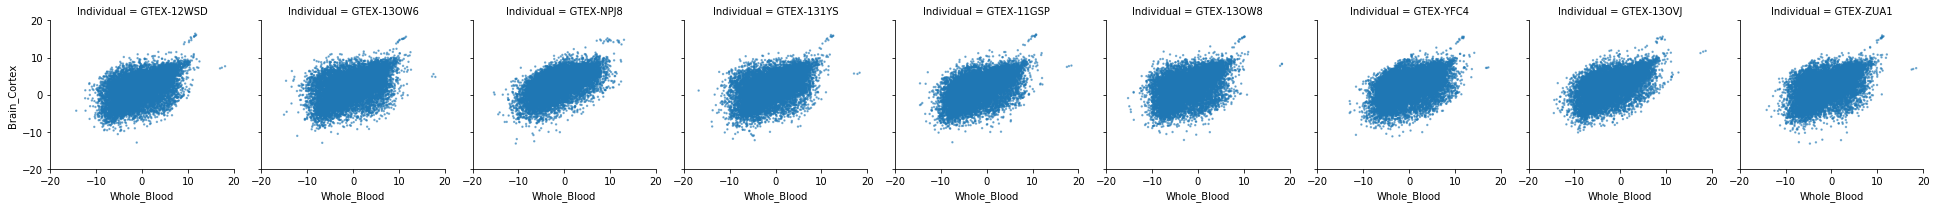

In [16]:
tissue_tissue("Whole Blood", "Brain - Cortex", 10, "Whole_Blood", "Brain_Cortex", gtex_tpm, tpm=True)

In [131]:
tissue_tissue("Whole Blood", "Thyroid", 10, "Whole_Blood", "Thyroid", gtex_tpm)
tissue_tissue("Whole Blood", "Lung", 10, "Whole_Blood", "Lung", gtex_tmp)

IndexError: tuple index out of range

#### Tissue-tissue log ratios correlation

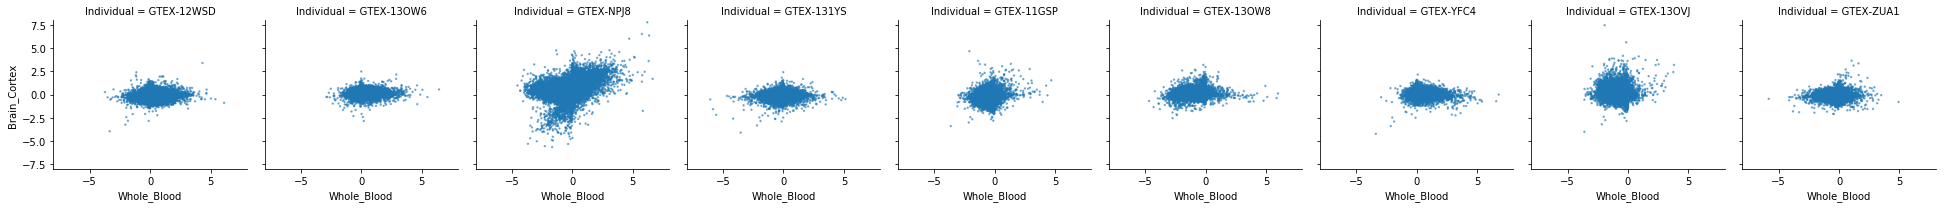

In [110]:
tissue_tissue("Whole Blood", "Brain - Cortex", 10, "Whole_Blood", "Brain_Cortex", gtex)

In [71]:
tissue_tissue("Whole Blood", "Brain - Cortex", 10, "Whole_Blood", "Brain_Cortex", gtex_tpm, tpm=True)
tissue_tissue("Whole Blood", "Thyroid", 10, "Whole_Blood", "Thyroid", gtex_tpm, tpm=True)
tissue_tissue("Whole Blood", "Lung", 10, "Whole_Blood", "Lung", gtex, tpm=True)

In [71]:
# tissue_tissue("Whole Blood", "Artery - Tibial", 10, "Whole_Blood", "Artery_Tibial", gtex)
# tissue_tissue("Whole Blood", "Artery - Tibial", 10, "Whole_Blood", "Artery_Tibial", gtex_tpm, tpm=True)
# tissue_tissue("Whole Blood", "Lung", 10, "Whole_Blood", "Lung", gtex)
# tissue_tissue("Whole Blood", "Whole Blood", 10, "Whole_Blood", "Whole_Blood", gtex)
# tissue_tissue("Whole Blood", "Cells - Transformed fibroblasts", 10, "Whole_Blood", "Cells_Transformed_fibroblasts", gtex)
# tissue_tissue("Whole Blood", "Skin - Sun Exposed (Lower leg)", 10, "Whole_Blood", "Skin", gtex)

### 4. Compute metadata
We need a summary of the experiments by individuals, tissues and genes.

#### 4.1. Dispersion index
For genes, we computed already the avg(TPM) per tissue for each of the 53 tissues.<br/>
In order to identify tissue specific genes, we compute the index of dispersion (std.dev/mean), where std.dev and mean are the parameters for the avg(TPM) distribution across tissues.<br/>
- index_dispersion >1, gene is more likely to be tissue specific
- index_dispersion <1, gene has a low variance across different tissues == expressed in all tissues (we choose those genes with mean > 400)

In [36]:
# index of dispersion
stats['index_dispersion'] = stats['Std.Dev']/stats['mean']

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
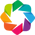

In [73]:
import datashader as ds, pandas as pd
import datashader.transfer_functions as tf
import holoviews as hv
import holoviews.operation.datashader as hd

hd.shade.cmap=["lightblue", "darkblue"]
hv.extension("bokeh", "matplotlib")

# %%output backend="matplotlib"
%matplotlib inline

cvs = ds.Canvas(plot_width=300, plot_height=300,x_range=(0,8), y_range=(0,1000), x_axis_type='linear', y_axis_type='linear')
agg = cvs.points(stats, 'index_dispersion', 'mean')
img = tf.shade(agg, cmap=['lightblue', 'darkblue'])
# hd.shade(hv.Image(agg))

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
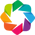

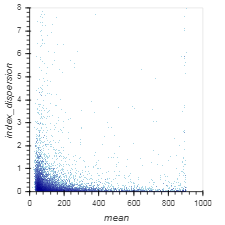

In [102]:
po.show_img("3_baseline_mean_tissue_gtex_files/index_dispersion_genes.png")

#### 4.2. Top Tissues

In [20]:
file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_logratios.h5ad")
gtex = p.load(file)

In [21]:
top_tissues = gtex.samples[['Tissue']].groupby(['Tissue'], sort=True).size().sort_values(ascending=False)
top_tissues[:15].index.tolist()

['Muscle - Skeletal',
 'Whole Blood',
 'Skin - Sun Exposed (Lower leg)',
 'Adipose - Subcutaneous',
 'Lung',
 'Artery - Tibial',
 'Thyroid',
 'Nerve - Tibial',
 'Esophagus - Mucosa',
 'Cells - Transformed fibroblasts',
 'Esophagus - Muscularis',
 'Heart - Left Ventricle',
 'Skin - Not Sun Exposed (Suprapubic)',
 'Artery - Aorta',
 'Adipose - Visceral (Omentum)']

#### 4.3. Top Individuals

In [22]:
tissues_per_indiv = gtex.samples[['Individual','Tissue']].drop_duplicates().groupby(['Individual'], sort=True).size().sort_values(ascending=False)
tissues_per_indiv[:50].index.tolist()

['GTEX-12WSD',
 'GTEX-ZAB4',
 'GTEX-13OW6',
 'GTEX-NPJ8',
 'GTEX-131YS',
 'GTEX-11GSP',
 'GTEX-13OW8',
 'GTEX-YFC4',
 'GTEX-13OVJ',
 'GTEX-ZUA1',
 'GTEX-12ZZX',
 'GTEX-T5JC',
 'GTEX-WY7C',
 'GTEX-T6MN',
 'GTEX-WZTO',
 'GTEX-Y114',
 'GTEX-11DXX',
 'GTEX-Y3IK',
 'GTEX-RU72',
 'GTEX-1313W',
 'GTEX-13NYB',
 'GTEX-Q2AG',
 'GTEX-11TT1',
 'GTEX-XV7Q',
 'GTEX-13PVQ',
 'GTEX-XUJ4',
 'GTEX-N7MS',
 'GTEX-TSE9',
 'GTEX-13OVL',
 'GTEX-WYVS',
 'GTEX-11EQ9',
 'GTEX-13G51',
 'GTEX-13O3O',
 'GTEX-YEC4',
 'GTEX-WHSE',
 'GTEX-12BJ1',
 'GTEX-13O3Q',
 'GTEX-WYJK',
 'GTEX-13N1W',
 'GTEX-11WQK',
 'GTEX-X4EP',
 'GTEX-ZDXO',
 'GTEX-U3ZN',
 'GTEX-ZVT2',
 'GTEX-11TUW',
 'GTEX-11P7K',
 'GTEX-13FHO',
 'GTEX-Y5V6',
 'GTEX-13N2G',
 'GTEX-11I78']

In [37]:
metadata = {}
metadata['genes'] = {}
metadata['individuals'] = {}
metadata['tissues'] = {}
metadata['genes']['high_variance'] = {}
metadata['genes']['low_variance'] = {}

In [38]:
# high variance genes - likely to be tissue specific
metadata['genes']['high_variance'] = {}
hvar = stats[stats['index_dispersion'] > 1].sort_values(by='index_dispersion',ascending = False)
for index, row in hvar.iterrows(): 
    metadata['genes']['high_variance'][index] = row['index_dispersion']

hvar[:10].index.tolist()

['ENSG00000180259.9',
 'ENSG00000184761.7',
 'ENSG00000205442.12',
 'ENSG00000204548.3',
 'ENSG00000204979.7',
 'ENSG00000189357.8',
 'ENSG00000176679.8',
 'ENSG00000176746.6',
 'ENSG00000186788.13',
 'ENSG00000204279.7']

In [39]:
# low variance genes - expressed in all
metadata['genes']['low_variance'] = {}
lvar =  stats[(stats['index_dispersion'] < 1) & (stats['mean'] >= 400)].sort_values(by='index_dispersion')
for index, row in lvar.iterrows(): 
    metadata['genes']['low_variance'][index] = row['index_dispersion']
lvar[:10].index.tolist()

[]